In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.metrics import Recall, Precision

# import keras_tuner as kt
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam
# from keras.callbacks import CSVLogger

In [7]:
cols_drop_lstm = [ 'exp', 'segment', 'SubSegment', 'video',  'frame', 'path', 'n_masks^3', 'mask_area',
    'mask_centroid', 'mask_conf', 'mask_strength', 'bbox_id', 'bbox_area',
    'bbox_centroid', 'bbox_dim',  'Label']

In [67]:
def build_sequences(df_lstm, scaler, train = 0, target_col='label_LSTM', window_size=10):
    print(df_lstm['is_padding'].value_counts())
 
    features = [col for col in df_lstm.columns if col not in ['label_LSTM', 'is_padding']]
    df_lstm_features = df_lstm[features]
    df_lstm_target = df_lstm[['label_LSTM', 'is_padding']]
    
    if train:
        scaled_values = scaler.transform(df_lstm_features)
        # Update DataFrame in place
        df_lstm_features.iloc[:, :] = scaled_values
    else:
        scaled_values = scaler.transform(df_lstm_features)
        # Update DataFrame in place
        df_lstm_features.iloc[:, :] = scaled_values
    
    X_seqs, y_seqs = [], []
    
    df_lstm = pd.concat([df_lstm_features, df_lstm_target], axis=1)

    pad_indices = df_lstm[df_lstm['is_padding'] == 1].index.tolist()
    start_idx = 0

    for pad_idx in pad_indices + [len(df_lstm)]:
        chunk = df_lstm.iloc[start_idx:pad_idx]
        chunk = chunk[chunk['is_padding'] == 0]

        if len(chunk) >= window_size:
            for i in range(len(chunk) - window_size + 1):
                window = chunk.iloc[i:i + window_size]
                X_seqs.append(window[features].values)
                if window[target_col].sum() >= 5:
                    y_seqs.append(1)
                else:
                    y_seqs.append(0)
#                 y_seqs.append(window[target_col].iloc[-1])

        start_idx = pad_idx + 1

    print(f"Total sequences built: {len(X_seqs)}")
    return np.array(X_seqs), np.array(y_seqs)

In [89]:
# Prepare Training Set
# scaler = StandardScaler()
print("Prepare Training set...")
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\train_set.csv")
df_lstm.drop(cols_drop_lstm, axis=1, inplace=True)
df_lstm.describe()
scaler = StandardScaler()
scaler.fit(df_lstm.drop(['label_LSTM', 'is_padding'], axis=1))
x_train, y_train = build_sequences(df_lstm, scaler, train=1)
print("X shape:{}, y shape: {}".format(x_train.shape, y_train.shape))
df_lstm.describe()

Prepare Training set...
0    5947
1      28
Name: is_padding, dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18156\258098398.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm_features.iloc[:, :] = scaled_values


Total sequences built: 5699
X shape:(5699, 10, 8), y shape: (5699,)


,n_masks,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,label_LSTM,is_padding
count,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000,5975.000000
mean,2.190628,2046.916193,2860.739724,196.869695,36.915612,36.915612,72.273762,72.487078,0.663096,0.004686
std,1.671352,4947.521530,6262.890884,45.759144,28.261406,28.261406,83.463251,83.673751,0.472691,0.068301
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,352.333333,459.571429,192.413929,17.571429,17.571429,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1076.000000,1530.000000,205.740000,33.000000,33.000000,42.580000,41.250000,1.000000,0.000000
75%,3.000000,2220.250000,3127.000000,218.570000,48.833333,48.833333,138.705000,138.580000,1.000000,0.000000
max,13.000000,105154.000000,125538.000000,246.040000,366.000000,366.000000,320.020000,327.020000,1.000000,1.000000


In [90]:
print("Prepare Test set...")
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\test_set.csv")
df_lstm.drop(cols_drop_lstm, axis=1, inplace=True)
x_test, y_test = build_sequences(df_lstm, scaler)
print("X shape:{}, y shape: {}".format(x_test.shape, y_test.shape))
df_lstm.describe()

Prepare Test set...
0    2041
1      14
Name: is_padding, dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18156\258098398.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm_features.iloc[:, :] = scaled_values


Total sequences built: 1916
X shape:(1916, 10, 8), y shape: (1916,)


,n_masks,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,label_LSTM,is_padding
count,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000,2055.000000
mean,2.664720,1539.643723,2372.211108,179.719943,29.870219,29.870219,86.576019,86.585655,0.665207,0.006813
std,1.919762,3432.905792,5340.385367,57.299268,26.404753,26.404753,80.100188,79.916137,0.472033,0.082277
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,176.000000,226.500000,176.924167,13.000000,13.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,657.333333,906.500000,197.673333,23.200000,23.200000,78.900000,79.090000,1.000000,0.000000
75%,4.000000,1755.000000,2692.500000,208.787500,40.000000,40.000000,157.730000,157.350000,1.000000,0.000000
max,13.000000,59816.000000,94105.000000,231.700000,295.000000,295.000000,417.410000,416.590000,1.000000,1.000000


In [91]:
print("Prepare Validation set...")
df_lstm = pd.read_csv(r"F:\Work\Misc\Mentees\SodiumDisposal\val_set.csv")
df_lstm.drop(cols_drop_lstm, axis=1, inplace=True)
x_val, y_val = build_sequences(df_lstm, scaler)
print("X shape:{}, y shape: {}".format(x_val.shape, y_val.shape))
df_lstm.describe()

Prepare Validation set...
0    2059
1      13
Name: is_padding, dtype: int64


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18156\258098398.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lstm_features.iloc[:, :] = scaled_values


Total sequences built: 1944
X shape:(1944, 10, 8), y shape: (1944,)


,n_masks,avg_mask_area,avg_bbox_area,avg_mask_strength,avg_bbox_width,avg_bbox_height,mask_centroid_dist,bbox_centroid_dist,label_LSTM,is_padding
count,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000,2072.000000
mean,2.067085,1122.655287,1619.241439,184.697985,26.763026,26.763026,60.842592,61.223639,0.741313,0.006274
std,1.542521,2285.632535,3452.320766,57.391949,20.677982,20.677982,74.326968,74.431659,0.438019,0.078980
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,240.375000,299.750000,181.660000,14.666667,14.666667,0.000000,0.000000,0.000000,0.000000
50%,2.000000,549.125000,736.428571,204.504167,22.333333,22.333333,27.160000,28.620000,1.000000,0.000000
75%,3.000000,1183.750000,1657.666667,214.606750,33.000000,33.000000,108.040000,109.070000,1.000000,0.000000
max,10.000000,33759.000000,53040.000000,241.680000,208.000000,208.000000,419.940000,416.820000,1.000000,1.000000


In [92]:
# Combine train + val
x_train = np.vstack((x_train, x_val))
y_train = np.concatenate((y_train, y_val))
print(x_train.shape, y_train.shape)

(7643, 10, 8) (7643,)


In [97]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
model = Sequential()
model.add(LSTM(units=16, dropout = 0.2, recurrent_dropout = 0.2,
               activation='tanh',# return_sequences=True,
               input_shape=(10, 8)))
#     model.add(Dropout(0.3))
#     model.add(LSTM(32)),
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate= 0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy',Recall(), Precision()])

In [98]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test)) #, class_weight=class_weights_dict)
#     model.save("lstm_model_best_recall_50ep.h5")
# Evaluate on Test Set
y_pred_prob = model.predict(x_test)
hist_list.append(history)
y_pred_class = (y_pred_prob > 0.5).astype(int)
report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
rep_list.append(report)

Epoch 1/20
239/239 [==============================] - 7s 13ms/step - loss: 0.6548 - accuracy: 0.6040 - recall_17: 0.5517 - precision_17: 0.8385 - val_loss: 0.6228 - val_accuracy: 0.7370 - val_recall_17: 0.7577 - val_precision_17: 0.8568
Epoch 2/20
239/239 [==============================] - 3s 13ms/step - loss: 0.5863 - accuracy: 0.7820 - recall_17: 0.8115 - precision_17: 0.8743 - val_loss: 0.5449 - val_accuracy: 0.8022 - val_recall_17: 0.8558 - val_precision_17: 0.8653
Epoch 3/20
239/239 [==============================] - 3s 12ms/step - loss: 0.5084 - accuracy: 0.8345 - recall_17: 0.9088 - precision_17: 0.8661 - val_loss: 0.4719 - val_accuracy: 0.8032 - val_recall_17: 0.8690 - val_precision_17: 0.8570
Epoch 4/20
239/239 [==============================] - 3s 11ms/step - loss: 0.4386 - accuracy: 0.8448 - recall_17: 0.9353 - precision_17: 0.8597 - val_loss: 0.4322 - val_accuracy: 0.8069 - val_recall_17: 0.8748 - val_precision_17: 0.8572
Epoch 5/20
239/239 [==============================] 

In [ ]:
y_pred_prob = model.predict(x_val)
hist_list.append(history)
y_pred_class = (y_pred_prob > 0.5).astype(int)
report = classification_report(y_test, y_pred_class, output_dict=True, zero_division=0)
report

In [66]:
report

{'0': {'precision': 0.5780141843971631,
  'recall': 0.7964169381107492,
  'f1-score': 0.6698630136986302,
  'support': 614},
 '1': {'precision': 0.883177570093458,
  'recall': 0.7258064516129032,
  'f1-score': 0.7967959527824622,
  'support': 1302},
 'accuracy': 0.7484342379958246,
 'macro avg': {'precision': 0.7305958772453105,
  'recall': 0.7611116948618262,
  'f1-score': 0.7333294832405461,
  'support': 1916},
 'weighted avg': {'precision': 0.7853851281218895,
  'recall': 0.7484342379958246,
  'f1-score': 0.7561191132221945,
  'support': 1916}}

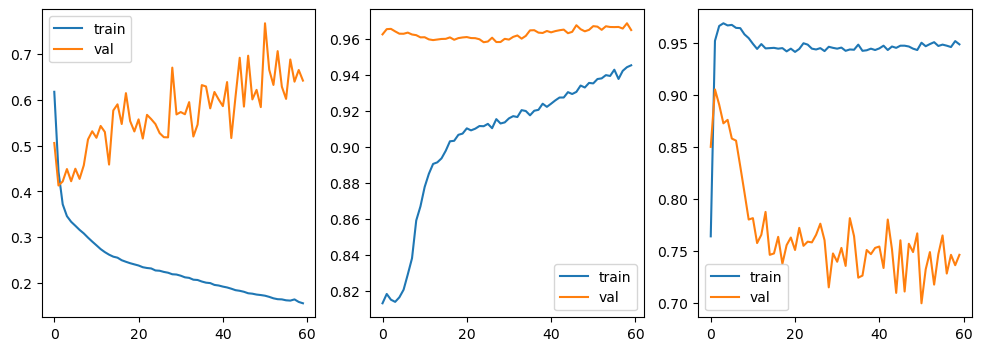

In [51]:
plt.figure(figsize=(12,4))
i=8
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history['precision_' + str(i)], label='train')
plt.plot(history.history['val_precision_' + str(i)], label = 'val')
plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history['recall_' + str(i)], label='train')
plt.plot(history.history['val_recall_' + str(i)], label = 'val')
plt.legend()

KeyError: 'precision_1'

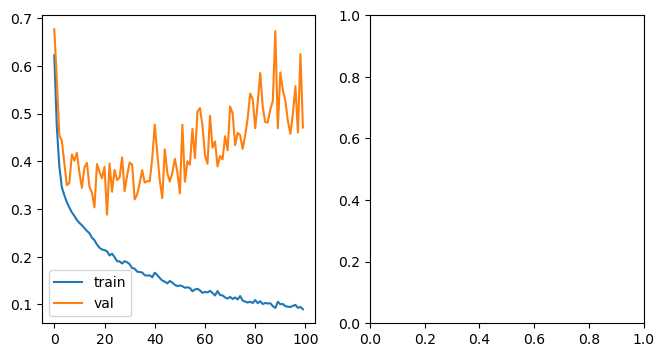

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = 'val')
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history['precision_1'], label='train')
plt.plot(history.history['val_precision_1'], label = 'val')
plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history['recall_1'], label='train')
plt.plot(history.history['val_recall_1'], label = 'val')
plt.legend()